<center><img src="https://i.imgur.com/zRrFdsf.png" width="700"></center>






# Neighboorhood and Spatial Correlation.



## Getting ready

Let me get two maps:

1. The USA map, at states level,  directly from census.gov, which has a good quality.

In [66]:
url = "https://www2.census.gov/geo/tiger/GENZ2023/shp/cb_2023_us_state_500k.zip"
us_states = gpd.read_file(url)
us_states.info(),us_states.crs.to_epsg(),us_states.crs.is_projected

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   56 non-null     object  
 1   STATENS   56 non-null     object  
 2   GEOIDFQ   56 non-null     object  
 3   GEOID     56 non-null     object  
 4   STUSPS    56 non-null     object  
 5   NAME      56 non-null     object  
 6   LSAD      56 non-null     object  
 7   ALAND     56 non-null     int64   
 8   AWATER    56 non-null     int64   
 9   geometry  56 non-null     geometry
dtypes: geometry(1), int64(2), object(7)
memory usage: 4.5+ KB


(None, 4269, False)

Notice this map has basic information per state. Also, notice the current crs will plot this:

<Axes: >

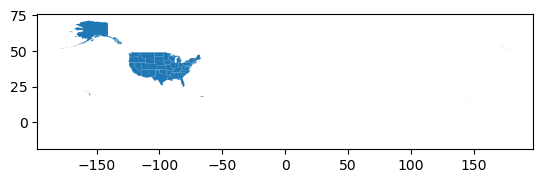

In [67]:
us_states.plot()

Let's reproject this map:

<Axes: >

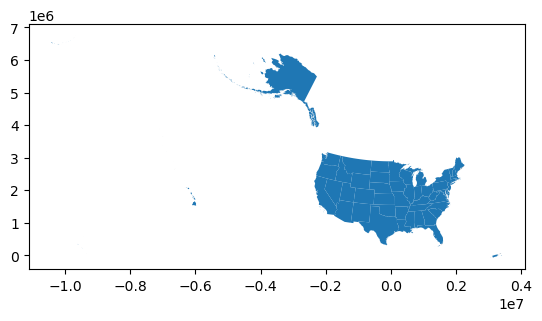

In [68]:
us_states=us_states.to_crs(5070)
us_states.plot()

Let's use the state name as index, that would help an easier identification:

In [78]:
us_states.set_index('NAME', inplace=True)
us_states.head()

,STATEFP,STATENS,GEOIDFQ,GEOID,STUSPS,LSAD,ALAND,AWATER,geometry
NAME,,,,,,,,,
New Mexico,35,00897535,0400000US35,35,NM,00,314198587197,726463919,"POLYGON ((-1231344.076 1018550.43, -1231015.83..."
South Dakota,46,01785534,0400000US46,46,SD,00,196341525171,3387709166,"POLYGON ((-633765.574 2472338.835, -633207.122..."
California,06,01779778,0400000US06,06,CA,00,403673296401,20291770234,"MULTIPOLYGON (((-2066923.367 1403703.122, -206..."
Kentucky,21,01779786,0400000US21,21,KY,00,102266598312,2384223544,"MULTIPOLYGON (((584560.04 1518183.089, 585066...."
Alabama,01,01779775,0400000US01,01,AL,00,131185049346,4582326383,"MULTIPOLYGON (((760323.731 857474.728, 760524...."


2. A map of Peru, at the 'distrito' level (similar to municipality in the USA - not exactly the same). The map comes from an unoffical [website](https://www.geogpsperu.com/p/descargas.html). Some columns have been added.

In [313]:
peruDataLink="https://github.com/CienciaDeDatosEspacial/dataSets/raw/refs/heads/main/PERU/PeruMaps.gpkg"
peru_distritos=gpd.read_file(peruDataLink,layer='distritos')
peru_distritos.info(),peru_distritos.crs.to_epsg(),peru_distritos.crs.is_projected

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1874 entries, 0 to 1873
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   DEPARTAMEN                1874 non-null   object  
 1   PROVINCIA                 1874 non-null   object  
 2   DISTRITO                  1874 non-null   object  
 3   Ubigeo                    1874 non-null   object  
 4   Poblacion                 1874 non-null   int64   
 5   Superficie                1874 non-null   float64 
 6   IDH2019                   1874 non-null   float64 
 7   Educ_sec_comp2019_pct     1874 non-null   float64 
 8   NBI2017_pct               1874 non-null   float64 
 9   Viv_sin_serv_hig2017_pct  1874 non-null   float64 
 10  geometry                  1874 non-null   geometry
dtypes: float64(5), geometry(1), int64(1), object(4)
memory usage: 161.2+ KB


(None, 4326, False)

Let's reproject and plot:

<Axes: >

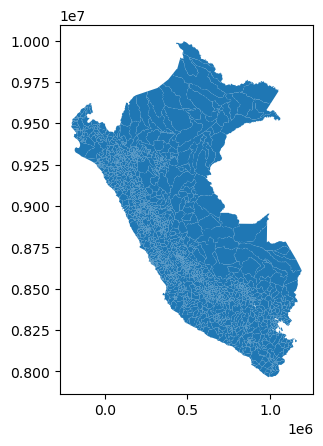

In [314]:
peru_distritos=peru_distritos.to_crs(5387)
peru_distritos.plot()

Besides the spatial units (DEPARTAMEN, PROVINCIA, DISTRITO, and Ubigeo - "Ubigeo" is a code ), you have:
 - Poblacion: Population (2017)
 - Superficie: Area               
 - IDH2019: Human Development Index for DISTRITO (2019)                   
 - Educ_sec_comp2019_pct: Share of Population that finished High-School (2019)     
 - NBI2017_pct: Share of Population with poverty at the household level aggregated by DISTRITO. This index ("Unsatisfied Basic Needs") uses observable living conditions rather than income alone (2017).
 - Viv_sin_serv_hig2017_pct: Share of housing units that have no sanitation infrastructure aggregated by  DISTRITO (2017)

## Who is my neighbor?

The basic idea is pretty simple; but as usual in social matters, a simple concept may have  different definitions. If we restrict our concept to spatial matters, a neighbor is whoever or whichever is close or nearby. 

So far we have found ways to 'detect' a neighbor for a particular spatial unit:

- Whichever is within a radius, using buffers.
- Whichever touches my boundaries, using sjoins.
- Whichever is within an area of interest, using sjoins/overlays.

In all the above, distance and set operations have played a major role. Now let's explore a different approach—a relational one—where the concepts from chess (rook, queen) become surprisingly useful.

Take a look at the **queen** and **rook** relationship:

<center><img src="https://github.com/CienciaDeDatosEspacial/spatial_autoCorr/raw/main/rookQueen.png" width="700"></center>

From the image above:
- Your **rook** neighbor is whichever  shares a border with you (a borderline of at least two points). It is also known as the _Von Neumann_ neighbor.
- Your **queen** neighbor is whichever  shares a border or a corner with you (at least one point).It is also known as the _Moore_ neighbor.


### The rook neighbor

Who is your Rook neighbor? **build_contiguity** (from _libpysal.graph_) has the answer.

In [79]:
from libpysal.graph import Graph

us_states_rook=Graph.build_contiguity(us_states,rook=True)

What did we just get?

In [86]:
type(us_states_rook)

libpysal.graph.base.Graph

Do not get confused in the next step. Since we have a **graph**, the **plot()** function call will active **Pysal's plot()**, not **Geopandas' plot()**. But notice a GDF is required, so Pysal and Geopandas work together well: 

<Axes: >

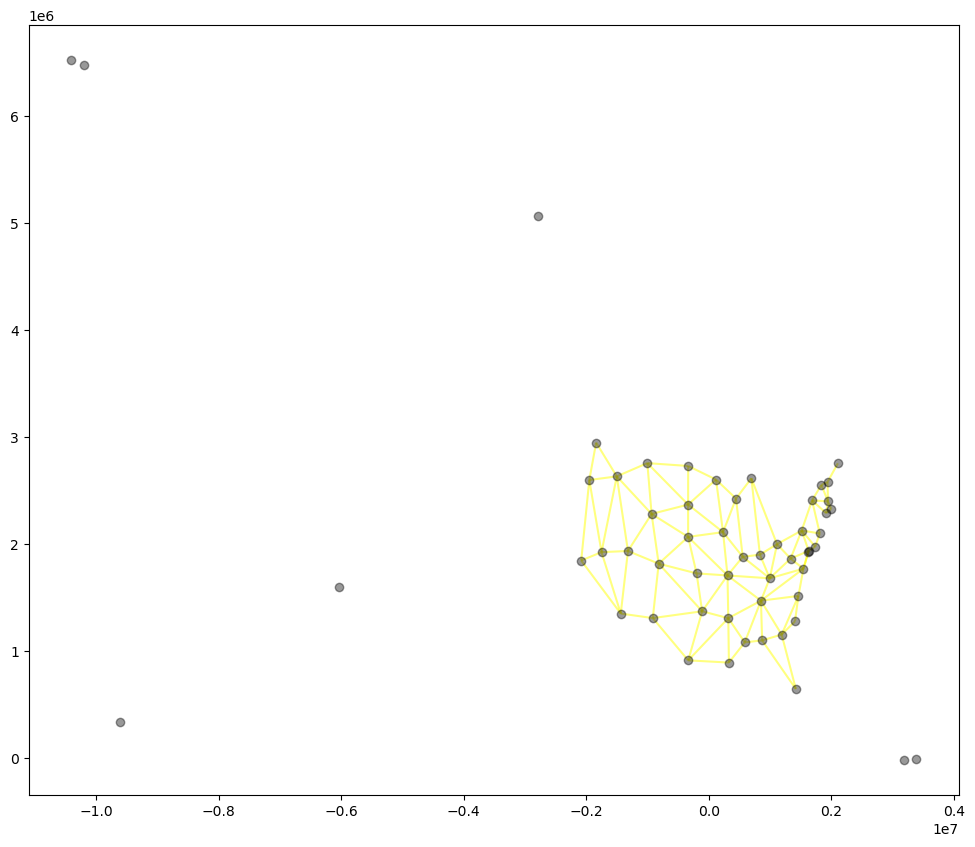

In [95]:
us_states_rook.plot(us_states, node_kws=dict(alpha=0.4), edge_kws=dict(alpha=0.5, color='yellow'),figsize=(12, 10))

For sure, both can work combined:

<Axes: >

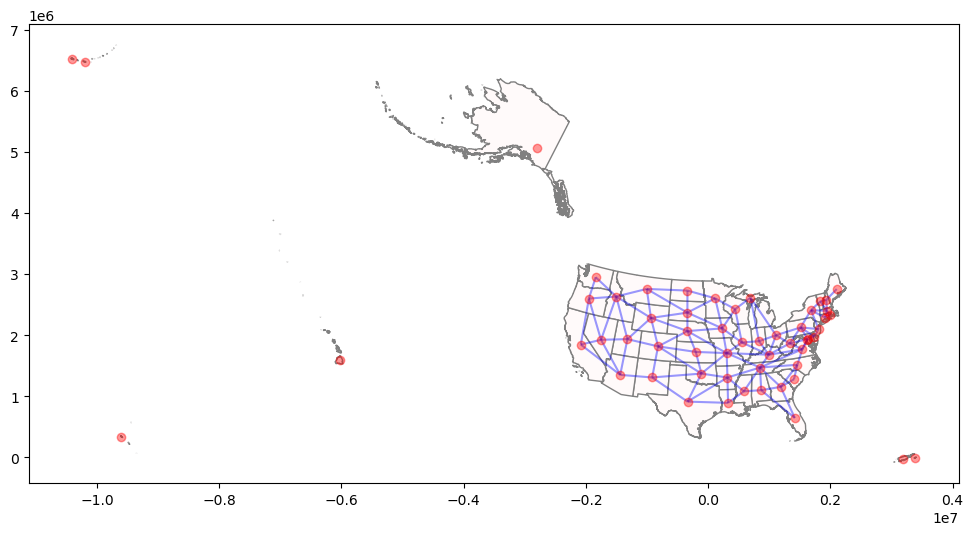

In [102]:
# First plot the polygons (the GDF)
base=us_states.plot(color='snow', edgecolor='grey',figsize=(12, 10))

# Then plot the graph on top
us_states_rook.plot(
    us_states,                    # ← Provides the spatial coordinates
    ax=base,                      # ← Same axis
    node_kws=dict(alpha=0.4,color='red'),     # ← Style for polygon centroids (nodes)
    edge_kws=dict(alpha=0.4,color='blue')      # ← Style for connections (edges)
)

We can know several interesting information from this output:

1. Count of nodes, count of rook neighbor relationships

In [134]:
us_states_rook.n, us_states_rook.n_edges/2

(56, 107.0)

2. For each state(focal node) which is a neighbor?

In [141]:
us_states_rook.adjacency

focal          neighbor   
New Mexico     Colorado       1
               Oklahoma       1
               Arizona        1
               Texas          1
South Dakota   Wyoming        1
                             ..
West Virginia  Ohio           1
               Virginia       1
Louisiana      Arkansas       1
               Texas          1
               Mississippi    1
Name: weight, Length: 221, dtype: int64

In [177]:
us_states_rook.cardinalities

focal
New Mexico                                      4
South Dakota                                    6
California                                      3
Kentucky                                        7
Alabama                                         4
Georgia                                         5
Arkansas                                        6
Pennsylvania                                    6
Missouri                                        8
Colorado                                        6
Utah                                            5
Oklahoma                                        6
Tennessee                                       8
Wyoming                                         6
New York                                        5
Indiana                                         4
Kansas                                          4
Idaho                                           6
Alaska                                          0
Nevada                                      

<Axes: xlabel='cardinalities'>

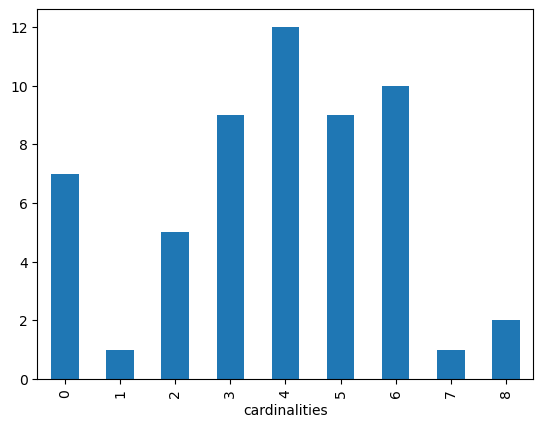

In [183]:
us_states_rook.cardinalities.value_counts().sort_index().plot.bar()

<Axes: xlabel='cardinalities'>

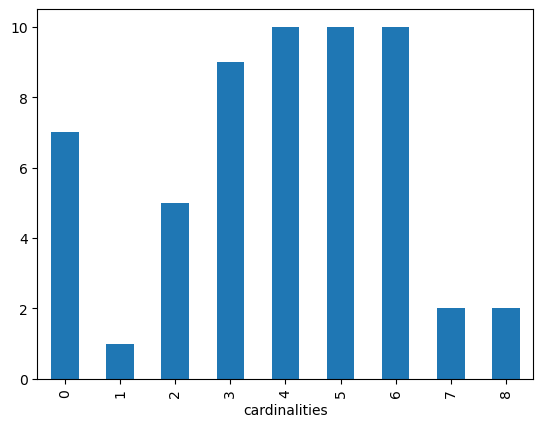

In [184]:
us_states_queen=Graph.build_contiguity(us_states,rook=False)
us_states_queen.cardinalities.value_counts().sort_index().plot.bar()

In [196]:
check=['Colorado']

us_states_rook.adjacency.loc[check]

focal     neighbor  
Colorado  New Mexico    1
          Utah          1
          Oklahoma      1
          Wyoming       1
          Kansas        1
          Nebraska      1
Name: weight, dtype: int64

In [193]:
us_states_queen.adjacency.loc[check]

focal     neighbor  
Colorado  New Mexico    1
          Utah          1
          Oklahoma      1
          Wyoming       1
          Kansas        1
          Arizona       1
          Nebraska      1
Name: weight, dtype: int64

The difference is due to the Four Corners Monument where Colorado meets Utah, Arizona, and New Mexico at a single point.

In [204]:
us_states_knn4 = Graph.build_knn(us_states.representative_point(), k=4)
us_states_knn8 = Graph.build_knn(us_states.representative_point(), k=8)

<Axes: >

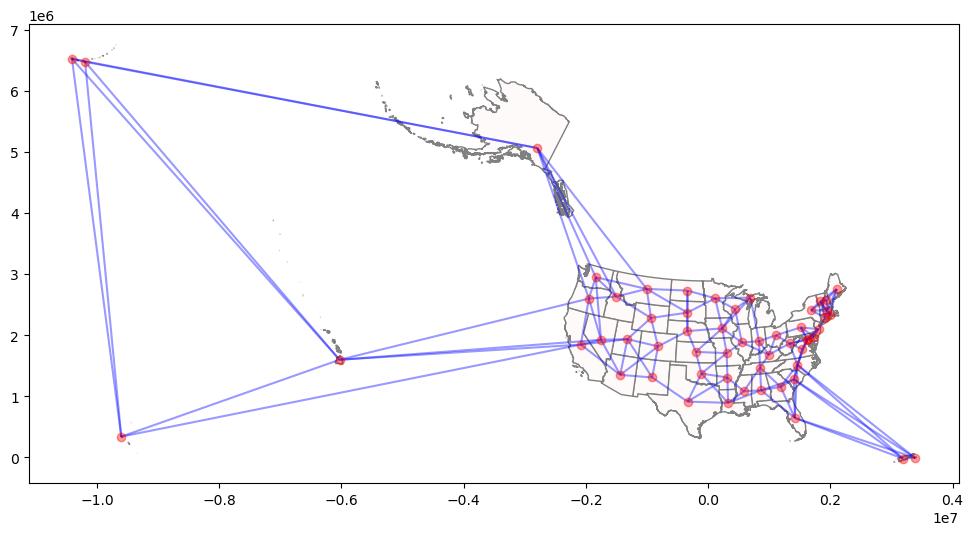

In [205]:
# First plot the polygons (the GDF)
base=us_states.plot(color='snow', edgecolor='grey',figsize=(12, 10))

# Then plot the graph on top
us_states_knn4.plot(
    us_states,                    # ← Provides the spatial coordinates
    ax=base,                      # ← Same axis
    node_kws=dict(alpha=0.4,color='red'),     # ← Style for polygon centroids (nodes)
    edge_kws=dict(alpha=0.4,color='blue')      # ← Style for connections (edges)
)

<Axes: >

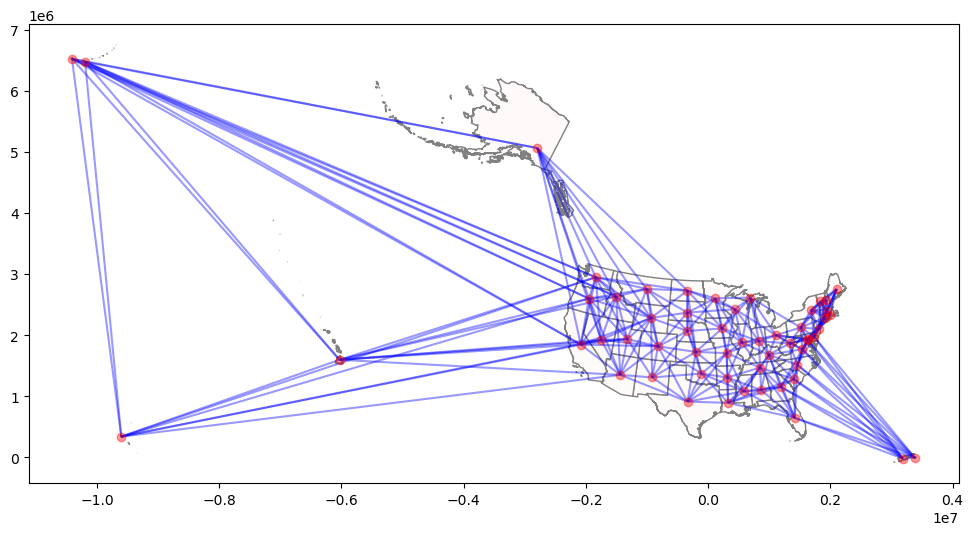

In [206]:
# First plot the polygons (the GDF)
base=us_states.plot(color='snow', edgecolor='grey',figsize=(12, 10))

# Then plot the graph on top
us_states_knn8.plot(
    us_states,                    # ← Provides the spatial coordinates
    ax=base,                      # ← Same axis
    node_kws=dict(alpha=0.4,color='red'),     # ← Style for polygon centroids (nodes)
    edge_kws=dict(alpha=0.4,color='blue')      # ← Style for connections (edges)
)

## Spatial autocorrelation

We are familiar with a several  ways to detect neighbors. Now comes the time to use this information combined with social data to produce analytics.

We have some social values here:

In [315]:
peru_distritos.head()

,DEPARTAMEN,PROVINCIA,DISTRITO,Ubigeo,Poblacion,Superficie,IDH2019,Educ_sec_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct,geometry
0,TACNA,TACNA,CORONEL GREGORIO ALBARRACIN LANCHIPA,230110,123662,187.74,0.578968,71.178389,15.8,0.8,"MULTIPOLYGON (((1010996.85 7988839.86, 1010945..."
1,TACNA,TACNA,POCOLLAY,230108,22319,265.65,0.645954,75.825743,16.1,0.9,"MULTIPOLYGON (((1037016.18 8010729.01, 1040111..."
2,TACNA,TACNA,CALANA,230103,3338,108.38,0.564102,77.829717,15.9,3.3,"MULTIPOLYGON (((1017798.86 8012856.01, 1017955..."
3,TACNA,TACNA,TACNA,230101,80845,1877.78,0.696613,75.491958,7.4,0.6,"MULTIPOLYGON (((996581.5 8009636.68, 997417.24..."
4,TACNA,TACNA,SAMA,230109,2679,1115.98,0.552622,70.500250,52.4,10.8,"MULTIPOLYGON (((985046.53 8016100.15, 979024.7..."


In [316]:
peru_distritos.Educ_sec_comp2019_pct.describe()

count    1874.000000
mean       55.769523
std        15.728123
min        11.974433
25%        44.466678
50%        57.164771
75%        68.202230
max        91.744878
Name: Educ_sec_comp2019_pct, dtype: float64

<Axes: >

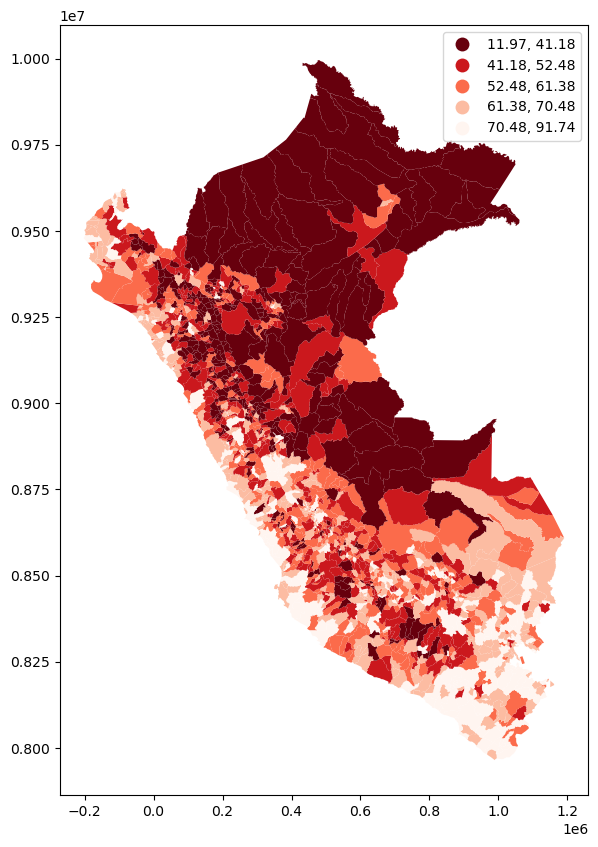

In [317]:
peru_distritos.plot(
    "Educ_sec_comp2019_pct",
    scheme="quantiles",
    cmap="Reds_r",
    legend=True,figsize=(12, 10))

### Spatial lag

In [318]:

# Reshape from long to wide format
adj_matrix = pd.DataFrame(us_states_rook.adjacency).reset_index()
adj_matrix_wide = adj_matrix.pivot_table(
    index='focal', 
    columns='neighbor', 
    values='weight',
    fill_value=0
)

adj_matrix_wide

neighbor,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Commonwealth of the Northern Mariana Islands,Connecticut,Delaware,...,Tennessee,Texas,United States Virgin Islands,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
focal,,,,,,,,,,,,,,,,,,,,,
Alabama,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alaska,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
American Samoa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Arizona,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Arkansas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
California,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Colorado,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
Commonwealth of the Northern Mariana Islands,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Connecticut,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [319]:
adj_matrix_wide.sum(axis=0)

neighbor
Alabama                                         4.0
Alaska                                          0.0
American Samoa                                  0.0
Arizona                                         4.0
Arkansas                                        6.0
California                                      3.0
Colorado                                        6.0
Commonwealth of the Northern Mariana Islands    0.0
Connecticut                                     3.0
Delaware                                        3.0
District of Columbia                            2.0
Florida                                         2.0
Georgia                                         5.0
Guam                                            0.0
Hawaii                                          0.0
Idaho                                           6.0
Illinois                                        5.0
Indiana                                         4.0
Iowa                                            6.0
Kan

In [320]:

us_states_rook_r=us_states_rook.transform("r")

adj_matrix_r = pd.DataFrame(us_states_rook_r.adjacency).reset_index()
adj_matrix_wide_r = adj_matrix_r.pivot_table(
    index='focal', 
    columns='neighbor', 
    values='weight',
    fill_value=0
)

adj_matrix_wide_r

neighbor,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Commonwealth of the Northern Mariana Islands,Connecticut,Delaware,...,Tennessee,Texas,United States Virgin Islands,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
focal,,,,,,,,,,,,,,,,,,,,,
Alabama,0.000,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000,...,0.250000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Alaska,0.000,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
American Samoa,0.000,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Arizona,0.000,0.0,0.0,0.000000,0.000000,0.25,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Arkansas,0.000,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000,...,0.166667,0.166667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
California,0.000,0.0,0.0,0.333333,0.000000,0.00,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Colorado,0.000,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667
Commonwealth of the Northern Mariana Islands,0.000,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Connecticut,0.000,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [321]:
adj_matrix_wide_r.sum(axis=1)

focal
Alabama                                         1.0
Alaska                                          0.0
American Samoa                                  0.0
Arizona                                         1.0
Arkansas                                        1.0
California                                      1.0
Colorado                                        1.0
Commonwealth of the Northern Mariana Islands    0.0
Connecticut                                     1.0
Delaware                                        1.0
District of Columbia                            1.0
Florida                                         1.0
Georgia                                         1.0
Guam                                            0.0
Hawaii                                          0.0
Idaho                                           1.0
Illinois                                        1.0
Indiana                                         1.0
Iowa                                            1.0
Kansas

In [322]:
peru_distritos[peru_distritos['DISTRITO'].duplicated()]

,DEPARTAMEN,PROVINCIA,DISTRITO,Ubigeo,Poblacion,Superficie,IDH2019,Educ_sec_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct,geometry
191,PUNO,LAMPA,PALCA,210706,2871,483.96,0.465326,68.506619,61.6,14.3,"MULTIPOLYGON (((980731.13 8315234.38, 980743.3..."
214,AYACUCHO,PAUCAR DEL SARA SARA,LAMPA,050804,2590,289.45,0.395363,60.608667,31.3,15.4,"MULTIPOLYGON (((666120.18 8335108.23, 666139.9..."
256,AYACUCHO,LUCANAS,SANTA LUCIA,050621,889,1019.14,0.442814,58.278405,64.7,47.6,"MULTIPOLYGON (((565436.58 8372074.78, 565495.3..."
259,AYACUCHO,LUCANAS,SAN CRISTOBAL,050615,2182,391.83,0.236161,68.230879,31.5,13.7,"MULTIPOLYGON (((576905.62 8374974.87, 577009.7..."
272,CUSCO,ESPINAR,COPORAQUE,080803,18004,1564.46,0.289550,75.551079,26.1,8.9,"MULTIPOLYGON (((863229.34 8390956.29, 863465.6..."
...,...,...,...,...,...,...,...,...,...,...,...
1844,LIMA,LIMA,LA VICTORIA,150115,169270,8.74,0.714159,74.791799,15.3,0.0,"MULTIPOLYGON (((280479.644 8666127.228, 280593..."
1845,LIMA,LIMA,SAN LUIS,150134,59377,3.49,0.793258,80.699041,9.4,0.0,"MULTIPOLYGON (((282530.051 8665926.351, 282499..."
1847,LIMA,LIMA,SAN MIGUEL,150136,139399,10.72,0.822401,76.664090,4.5,0.0,"MULTIPOLYGON (((273775.884 8664656.624, 273772..."
1855,LIMA,LIMA,SAN ISIDRO,150131,54298,11.10,0.788832,78.470219,1.1,0.0,"MULTIPOLYGON (((277019.308 8663207.821, 277130..."


In [323]:
peru_distritos_rook=Graph.build_contiguity(peru_distritos)

In [324]:
peru_distritos_rook=peru_distritos_rook.transform("r")
y = peru_distritos["Educ_sec_comp2019_pct"]
ylag = peru_distritos_rook.lag(y)
peru_distritos=peru_distritos.assign(Educ_sec_comp2019_pct_lagged=ylag)

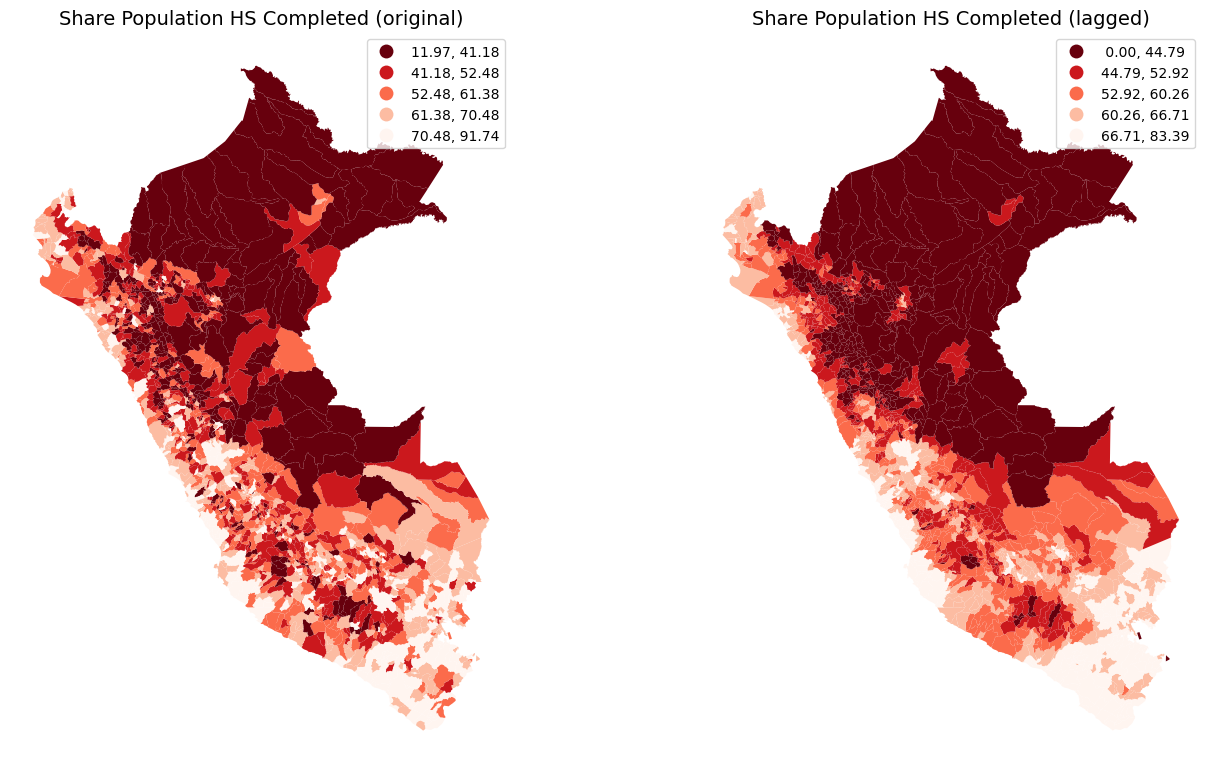

In [325]:

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

commonParams=dict(scheme="quantiles",cmap="Reds_r",legend=True)
# --- MAP 1
peru_distritos.plot("Educ_sec_comp2019_pct",ax=axes[0],**commonParams)
axes[0].set_title('Share Population HS Completed (original)', fontsize=14)
axes[0].set_axis_off()

# --- MAP 2
peru_distritos.plot("Educ_sec_comp2019_pct_lagged",ax=axes[1],**commonParams)
axes[1].set_title('Share Population HS Completed (lagged)', fontsize=14)
axes[1].set_axis_off()

plt.tight_layout()
plt.show()


<Axes: xlabel='Educ_sec_comp2019_pct', ylabel='Educ_sec_comp2019_pct_lagged'>

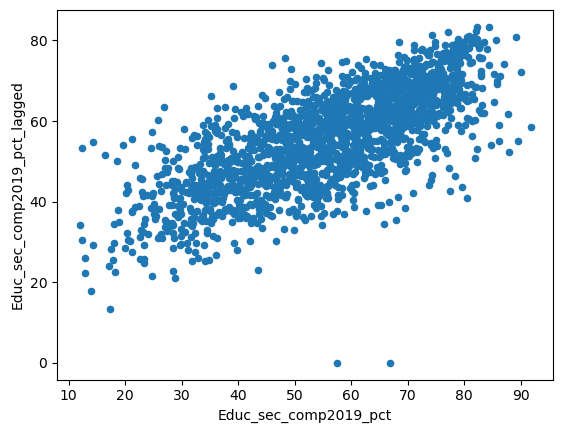

In [326]:
peru_distritos.plot.scatter("Educ_sec_comp2019_pct","Educ_sec_comp2019_pct_lagged")

In [327]:
from libpysal.weights import Queen, Rook, KNN

# rook
w_rook = Rook.from_dataframe(peru_distritos,use_index=False) 

/opt/anaconda3/envs/spatial_311py/lib/python3.11/site-packages/libpysal/weights/contiguity.py:61: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 89, 122.
  W.__init__(self, neighbors, ids=ids, **kw)


The presence of _islands_ will be problematic in more complex applications. An alternative is:

3) Nearest neighbors:

In [328]:
# k=8 nearest neighbors
w_knn8 = KNN.from_dataframe(peru_distritos, k=8)

In [329]:
w_knn8.islands

[]

## Global spatial correlation

If a spatial unit (a row) value in a variable is correlated with values of the neighbors, you know that proximity is interfering with the interpretation.

We need the neighboorhood matrix (the weight matrix) to compute spatial correlation.

If we standardize by row, the neighboors in a row add to 1:

In [330]:
# needed for spatial correlation
w_knn8.transform = 'R'

Spatial correlation is measured by the Moran's I statistic:

In [331]:
from esda.moran import Moran

moranHS = Moran(peru_distritos['Educ_sec_comp2019_pct'], w_knn8)
moranHS.I,moranHS.p_sim

(np.float64(0.5535272136923975), np.float64(0.001))

A significant Moran's I suggest spatial correlation. Let's see the spatial scatter plot

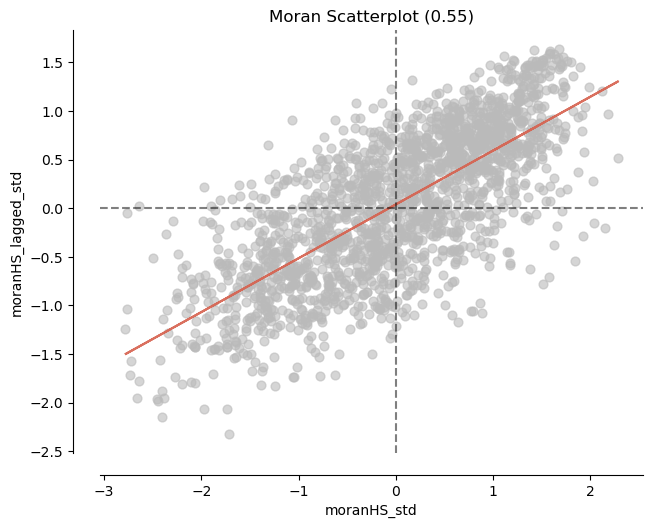

In [332]:
from splot.esda import moran_scatterplot

fig, ax = moran_scatterplot(moranHS, aspect_equal=True)
ax.set_xlabel('moranHS_std')
ax.set_ylabel('moranHS_lagged_std');

## Local Spatial Correlation

We can compute a Local Index of Spatial Association (LISA -local Moran) for each map object. That will help us find spatial clusters (spots) and spatial outliers:

* A **hotSpot** is a polygon whose value in the variable is high AND is surrounded with polygons with also high values.

* A **coldSpot** is a polygon whose value in the variable is low AND is surrounded with polygons with also low values.

* A **coldOutlier** is a polygon whose value in the variable is low BUT is surrounded with polygons with  high values.

* A **hotOutlier** is a polygon whose value in the variable is high BUT is surrounded with polygons with  low values.

It is also possible that no significant correlation is detected. Let's see those values:

In [333]:
# A LISA for each district using IDH2019
from esda.moran import Moran_Local
lisaHS = Moran_Local(y=peru_distritos['Educ_sec_comp2019_pct'], w=w_knn8,seed=2022)

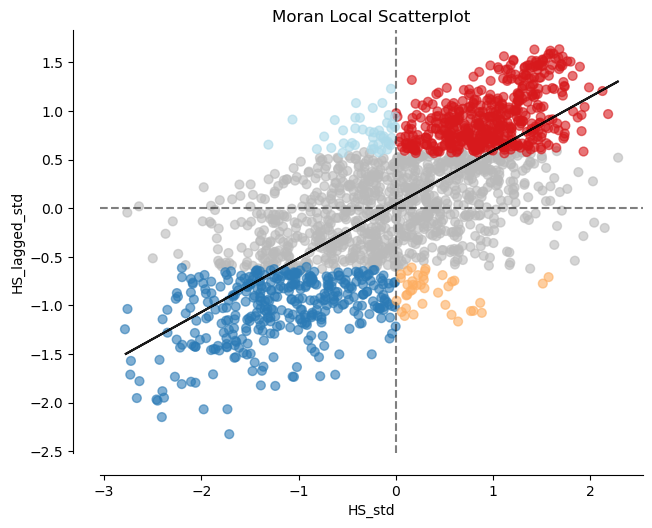

In [334]:
fig, ax = moran_scatterplot(lisaHS,p=0.05)
ax.set_xlabel('HS_std')
ax.set_ylabel('HS_lagged_std');

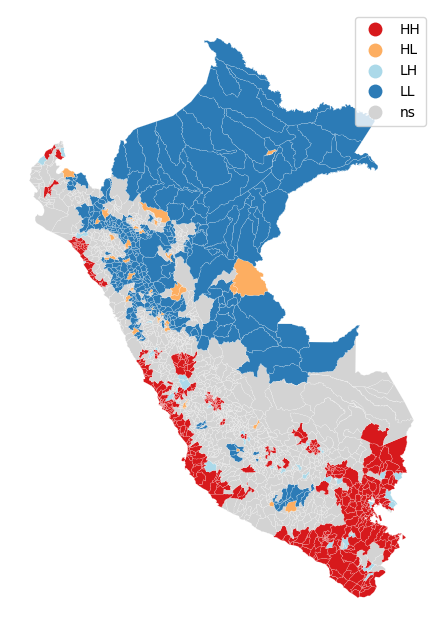

In [335]:
from splot.esda import lisa_cluster

lisa_cluster(lisaHS, peru_distritos, p=0.05, figsize=(8, 8))
plt.show()

In [336]:
peru_distritos

,DEPARTAMEN,PROVINCIA,DISTRITO,Ubigeo,Poblacion,Superficie,IDH2019,Educ_sec_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct,geometry,Educ_sec_comp2019_pct_lagged
0,TACNA,TACNA,CORONEL GREGORIO ALBARRACIN LANCHIPA,230110,123662,187.74,0.578968,71.178389,15.8,0.8,"MULTIPOLYGON (((1010996.85 7988839.86, 1010945...",75.491958
1,TACNA,TACNA,POCOLLAY,230108,22319,265.65,0.645954,75.825743,16.1,0.9,"MULTIPOLYGON (((1037016.18 8010729.01, 1040111...",75.465490
2,TACNA,TACNA,CALANA,230103,3338,108.38,0.564102,77.829717,15.9,3.3,"MULTIPOLYGON (((1017798.86 8012856.01, 1017955...",74.788676
3,TACNA,TACNA,TACNA,230101,80845,1877.78,0.696613,75.491958,7.4,0.6,"MULTIPOLYGON (((996581.5 8009636.68, 997417.24...",70.270296
4,TACNA,TACNA,SAMA,230109,2679,1115.98,0.552622,70.500250,52.4,10.8,"MULTIPOLYGON (((985046.53 8016100.15, 979024.7...",73.096296
...,...,...,...,...,...,...,...,...,...,...,...,...
1869,LIMA,LIMA,CIENEGUILLA,150109,50486,240.33,0.637172,69.643266,24.7,2.3,"MULTIPOLYGON (((311737.31 8672913.428, 312087....",73.582374
1870,LIMA,LIMA,ANCON,150102,42124,285.45,0.668889,72.117976,21.7,1.1,"MULTIPOLYGON (((274813.809 8719601.714, 274816...",67.856221
1871,LIMA,LIMA,CARABAYLLO,150106,322936,303.31,0.649869,74.114567,20.0,1.4,"MULTIPOLYGON (((293047.047 8702645.613, 293181...",66.659399
1872,CALLAO,CALLAO,MI PERU,070107,63542,2.52,0.643710,67.812626,17.1,0.2,"MULTIPOLYGON (((269591.778 8690057.047, 269636...",71.140478


In [337]:
lisaResults=pd.DataFrame({
    'quadrant': lisaHS.q,
    'p_value': lisaHS.p_sim,
    'significant': lisaHS.p_sim < 0.05
})

# quadrant: 1 HH,  2 LH,  3 LL,  4 HL
lisaResults

,quadrant,p_value,significant
0,1,0.001,True
1,1,0.001,True
2,1,0.001,True
3,1,0.001,True
4,1,0.001,True
...,...,...,...
1869,1,0.001,True
1870,1,0.001,True
1871,1,0.001,True
1872,1,0.001,True


In [338]:
lisaResults['HS_lisa']=[l if p <0.05 else 0 for l,p in zip(lisaHS.q,lisaHS.p_sim)  ]


lisaResults

,quadrant,p_value,significant,HS_lisa
0,1,0.001,True,1
1,1,0.001,True,1
2,1,0.001,True,1
3,1,0.001,True,1
4,1,0.001,True,1
...,...,...,...,...
1869,1,0.001,True,1
1870,1,0.001,True,1
1871,1,0.001,True,1
1872,1,0.001,True,1


In [339]:

labels = [ '0 no_sig', '1 hotSpot', '2 coldOutlier', '3 coldSpot', '4 hotOutlier']

lisaResults['HS_lisa_quadrant']=[labels[i] for i in lisaResults['HS_lisa']]

lisaResults['HS_lisa_quadrant'].value_counts()

HS_lisa_quadrant
0 no_sig         922
1 hotSpot        496
3 coldSpot       372
2 coldOutlier     45
4 hotOutlier      39
Name: count, dtype: int64

In [341]:
peru_distritos['HS_lisa_quadrant']=lisaResults['HS_lisa_quadrant']

In [342]:
peru_distritos.crs

<Projected CRS: EPSG:5387>
Name: Peru96 / UTM zone 18S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Peru - between 78°W and 72°W, onshore and offshore.
- bounds: (-78.0, -21.05, -72.0, -0.03)
Coordinate Operation:
- name: UTM zone 18S
- method: Transverse Mercator
Datum: Peru96
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<Axes: >

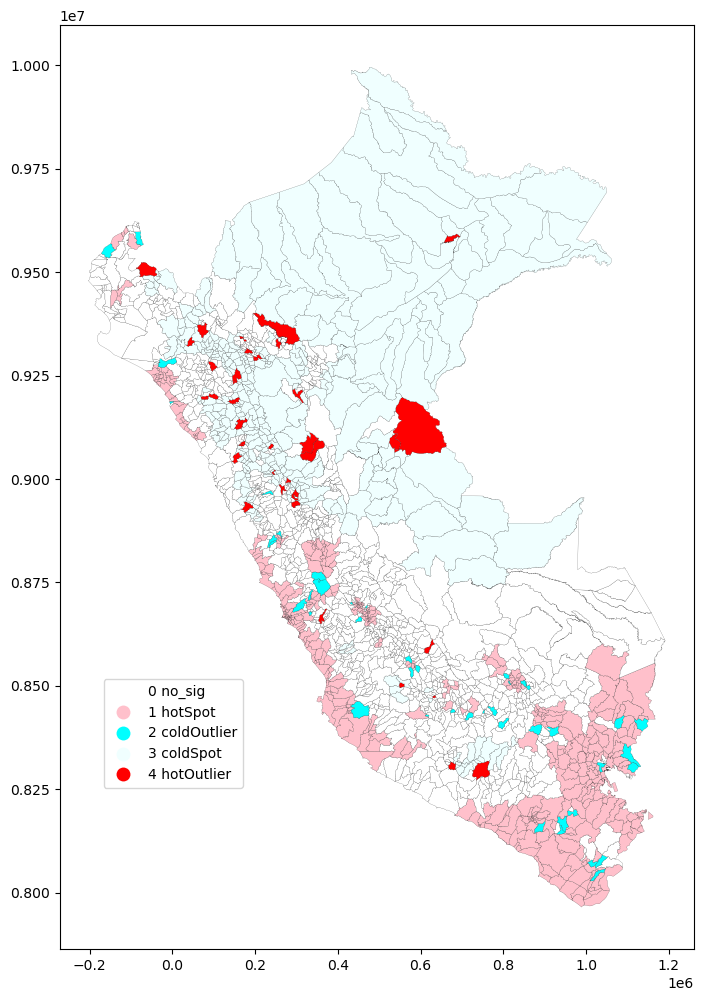

In [343]:
import matplotlib.pyplot as plt
# custom colors
from matplotlib import colors
myColMap = colors.ListedColormap([ 'white', 'pink', 'cyan', 'azure','red'])

peru_distritos.plot(column='HS_lisa_quadrant', 
                categorical=True,
                cmap=myColMap,
                linewidth=0.1, 
                edgecolor='k',
                legend=True,
                legend_kwds={'bbox_to_anchor': (0.3, 0.3)},
                figsize=(12,12))


You find that a district is in a **quadrant**. If the district is NOT grey, then the LISA is significant. Let's represent that information in a map, using the lisaIDH object:

The info in **lisaIDH.q** can not be used right away, we need to add if the local spatial correlation is significant:

Now, we recode: